# What makes an NBA All-Star?
### STAT 206 Final Project

#### Matthew Barclay
#### Riley Baumgarten
#### Arvind Kamboh

In [87]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 4 × Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake)
  Threads: 1 on 4 virtual cores
Environment:
  JULIA_NUM_THREADS = 
  DYLD_FALLBACK_LIBRARY_PATH = /Users/mattbarclay/.julia/artifacts/0233bb40b298b03aa3743cc339b4a5c6816ce583/lib:/Users/mattbarclay/.julia/artifacts/1e901863cf8fbb1ee50a5d0976114a2371899331/lib:/Users/mattbarclay/.julia/artifacts/dcc1b7719d5a106fba77bbc272d231e163d15fe5/lib:/Users/mattbarclay/.julia/juliaup/julia-1.10.0+0.x64.apple.darwin14/lib/julia:/Users/mattbarclay/.julia/artifacts/fdcdc342cc36e5c3be4f50d1b7754626d9d68cb4/lib:/Users/mattbarclay/.julia/artifacts/397fee52d94fc3404c3e466a6a8277ad9fdde715/lib:/Users/mattbarclay/.julia/artifacts/d2ea466e9d726fe2dc83e2179336f2098f5724a2/lib:/Users/mattbarclay/.julia/artifacts/

In [88]:
import Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/STAT206_Final_Project`


Status `~/STAT206_Final_Project/Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.107
  [da1fdf0e] FreqTables v0.4.6
⌃ [add582a8] MLJ v0.20.2
  [d354fa79] MLJClusteringInterface v0.1.11
  [c6f25543] MLJDecisionTreeInterface v0.4.1
  [094fc8d1] MLJFlux v0.4.0
  [61c7150f] MLJLIBSVMInterface v0.2.1
  [6ee0df7b] MLJLinearModels v0.10.0
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.3
  [54119dfa] MLJXGBoostInterface v0.3.10
  [636a865e] NearestNeighborModels v0.2.3
  [b8a86587] NearestNeighbors v0.4.16
⌃ [91a5bcdd] Plots v1.40.1
  [860ef19b] StableRNGs v1.0.1
  [f3b207a7] StatsPlots v0.15.7
  [009559a3] XGBoost v2.5.1
  [9a3f8284] Random
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [89]:
using CSV, DataFrames
using Plots, StatsPlots
using Distributions
using MLJ, MLJClusteringInterface
using NearestNeighbors, StableRNGs, Random
#import PlotlyJS as PJS#import because PlotlyJS overwrites all plots and statsplots
#using Colors
using MLJLIBSVMInterface
using FreqTables

## Introduction: 

In the landscape of professional basketball, achieving the status of an NBA All-Star represents a significant milestone in a basketball player’s career, symbolizing not only individual excellence but also recognition among peers and fans. Nevertheless, the process through which NBA players attain this distinction remains a multifaceted and often debated topic. This analysis project aims to investigate the determinants that influence the selection of NBA players as All-Stars. By examining factors such as point per game, minutes played, rebounds, and shot percentage, this project seeks to explore the dynamics shaping the All-Star selection process. 

## Data Summary: 

For this project, we used the NBA Player Stats Dataset for the 2022-2023 season, obtained from Kaggle. The actual data comes from the NBA statistical source Basketball Reference. This dataset comprises 500 rows and 30 columns, with each row representing an NBA player and each column denoting various statistical attributes such as points per game, assists, rebounds, and shooting percentages, among others. This dataset was augmented with outside data to include an additional column indicating whether a player has been selected as an All-Star in previous seasons, which provides valuable historical context for our analysis to distinguish the current players who were All-Stars. The only data cleaning required was consolidating the multiple rows caused by players having switched teams during the season into a single row for their season total statistics.  This dataset contains no missing values and presents a solid foundation for addressing our research question regarding the determinants influencing an NBA player's selection as an All-Star, given its comprehensive coverage of accurate player statistics and the NBA being such a highly data-driven organization.
Source: https://www.kaggle.com/datasets/bryanchungweather/nba-players-data-2022-2023  

Columns Description:
1. Rk: Rank
2. Player: Player's name
3. Pos: Position
4. Age: Player's age
5. Tm: Team
6. G: Games played
7. GSpct: Games started percentage
8. MP: Minutes played per game
9. FG: Field goals per game
10. FGA: Field goal attempts per game
11. FGpct: Field goal percentage
12. ThreeP: 3-point field goals per game
13. ThreePA: 3-point field goal attempts per game
14. ThreePpct: 3-point field goal percentage
15. TwoP: 2-point field goals per game
16. TwoPA: 2-point field goal attempts per game
17. TwoPpct: 2-point field goal percentage
18. eFGpct: Effective field goal percentage
19. FT: Free throws per game
20. FTA: Free throw attempts per game
21. FTpct: Free throw percentage
22. ORB: Offensive rebounds per game
23. DRB: Defensive rebounds per game
24. TRB: Total rebounds per game
25. AST: Assists per game
26. STL: Steals per game
27. BLK: Blocks per game
28. TOV: Turnovers per game
29. PF: Personal fouls per game (committed)
30. PPG: Points per game
31. ALLSTAR: All-Star status

In [90]:
nbadf = CSV.read("nba_2022_2023.csv", DataFrame, stringtype = String) |> dropmissing
#describe(nbadf)
rename!(nbadf,
Symbol("FG%")=>:FGpct,
Symbol("3P")=>:ThreeP,
Symbol("3PA")=>:ThreePA,
Symbol("3P%")=>:ThreePpct,
Symbol("2P")=>:TwoP,
Symbol("2PA")=>:TwoPA,
Symbol("2P%")=>:TwoPpct,
Symbol("eFG%")=>:eFGpct,
Symbol("FT%")=>:FTpct,
:PTS=>:PPG
)
multiteam = filter(:Tm=>==("TOT"),nbadf).Player #identify players on multiple teams
filter!(row -> row.Tm==("TOT") || !in(row.Player, multiteam),nbadf) #remove all rows but total for players on multiple teams
#Convert multi-positional to their main position
nbadf.Pos = first.(nbadf.Pos,2)
#filter(:Pos => in(["SG-PG","SF-SG","PG-SG","SF-PF","PF-C","PF-SF"]), nbadf)

allstars = CSV.read("nba_2022_2023_allstars.csv", DataFrame, stringtype = String)
leftjoin!(nbadf,allstars, on = :Player => :NAME)
replace!(nbadf.ALLSTAR, missing => "N")
#filter(:ALLSTAR=>==("Y"),nbadf)
nbadf.GSpct = nbadf.GS ./ nbadf.G
print(describe(nbadf))

31×7 DataFrame
 Row │ variable   mean      min         median   max              nmissing  eltype                 
     │ Symbol     Union…    Any         Union…   Any              Int64     Type                   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Player               A.J. Green           Zion Williamson         0  String
   2 │ Pos                  C                    SG                      0  String
   3 │ Age        25.8307   19          25.0     42                      0  Int64
   4 │ Tm                   ATL                  WAS                     0  String
   5 │ G          50.5      1           56.0     83                      0  Int64
   6 │ GS         24.0916   0           9.0      83                      0  Int64
   7 │ MP         20.6259   2.8         19.5     37.4                    0  Float64
   8 │ FG         3.51653   0.2         2.8      11.2                    0  Float64
   9 │ FGA        7.46

## Research Question: 

> What are the determinant factors influencing an NBA player's selection as an All-Star?

## Methods: 

In order to solve our research question, there are a few key methods that are vital in helping us analyze the data we were given:

*Exploratory Data Analysis (EDA)*

+ **Correlation Matrices:** To identify potential relationships between variables and remove predictors with extreme correlation values.

+ **Histograms and Boxplots:** These will be used to visualize the distribution of key variables and identify outliers or skewness in the data, providing insights into the data's characteristics.

+ **Principal Component Analysis (PCA):** PCA will be applied to reduce the dimensionality of the dataset, identifying a smaller number of uncorrelated variables (principal components) that capture most of the variance in the data.

*Predictive Modeling*

+ **Logistic Regression:** A baseline model due to its interpretability and effectiveness in binary classification tasks.
Decision Trees and Random Forests: These models are useful for handling nonlinear relationships and interactions between variables.

+ **K-Nearest Neighbors (KNN):** To explore the predictive power of player similarities in the context of All-Star selections.

+ **Linear Discriminant Analysis (LDA):** As a technique to find a linear combination of features that characterizes or separates two or more classes (All-Star selected/not selected).

+ **Neural Networks:** To model complex nonlinear relationships through a deep learning approach, potentially capturing intricate patterns in the data.

+ **XGBoost:** A gradient boosting framework that has been successful in various prediction tasks, known for its performance and speed.

*Addressing Potential Issues*

+ **Multicollinearity:** Before deploying logistic regression and other linear models, the correlation will be calculated and the raw data sources analyzed to identify and mitigate multicollinearity among predictors.

+ **Overfitting:** Regularization techniques, along with validation methods such as holdout-validation, will be applied to prevent overfitting, especially in complex models like neural networks and random forests.

By employing these methods, the determinants of NBA All-Star can be selected accurately, providing both predictive power and insights into the importance and influence of various factors.


## Results

### Correlation and Multicollinearity

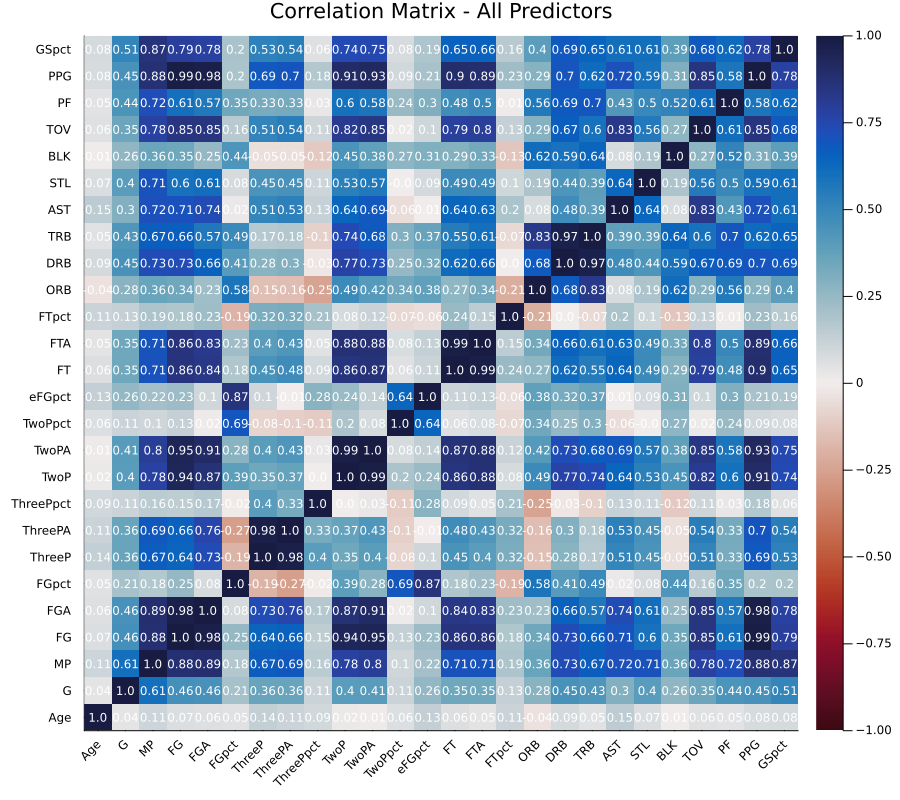

In [91]:
numeric_df = select(nbadf, Not([:Player, :Pos, :Tm, :ALLSTAR,:GS]))
vars = names(numeric_df)
X = Matrix(numeric_df)
M = cor(X)
fig = heatmap(M, 
    title="Correlation Matrix - All Predictors", 
    xticks=(1:26, vars), 
    yticks=(1:26, vars), 
    clims=(-1,1), 
    xrot=45,
    color=cgrad(:balance, rev=true), 
    aspect=:ratio, 
    size=(900, 800)
)

for j in axes(M,2), i in axes(M,1)
    annotate!(i,j, text("$(round(M[i,j], digits=2))", :white, 8))
end 
fig 

### Check for multicollinearity

The following predictors were removed from the dataset due to high correlation and issues with multicollinearity:
+ Shot attempts: There is high correlation between shots made and attempts, so it is better to use shots made and shot pct
+ eFGpct: According to [basketball-reference.com](https://www.basketball-reference.com/about/glossary.html), eFGpct = (FG + 0.5 * 3P) / FGA which is a linear equation of predictors
+ Field Goals: Field goals is just 2P + 3P, so it is collinear
+ Total Rebounds: Total rebounds is offensive + defensive rebounds, which is collinear
+ Points Per Game: Sum of all types of points made, so it is collinear with 2's, 3's, and free throws
+ Recommendation: Remove these predictors when creating linear models

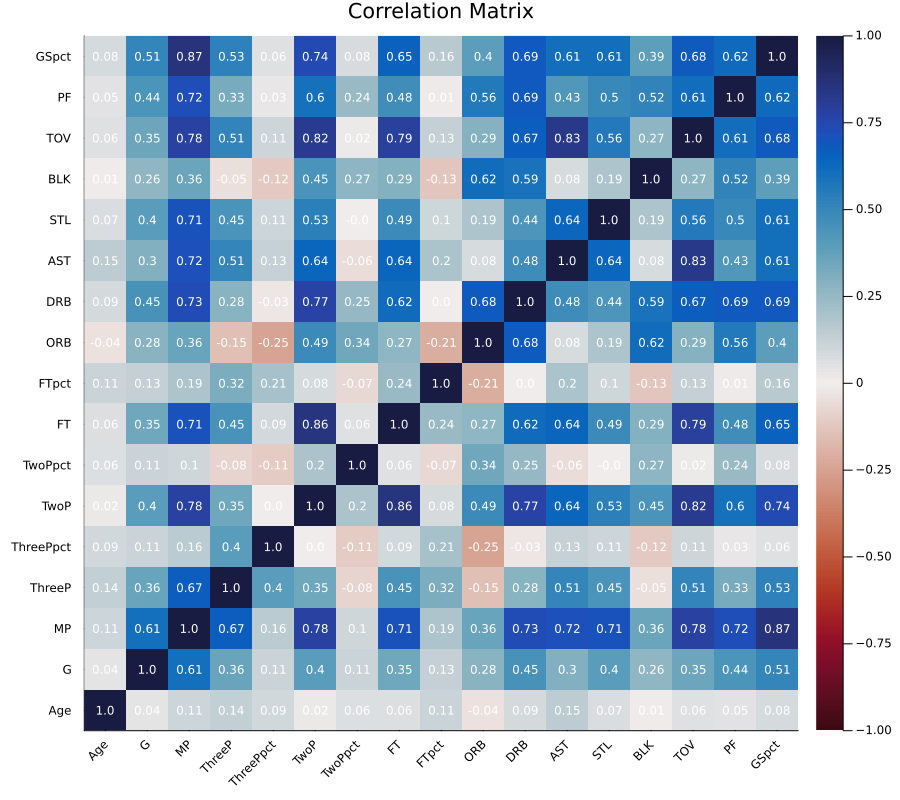

In [92]:
vars = names(select(numeric_df, Not([:FG,:FGA,:FGpct,:ThreePA,:TwoPA,:FTA,:TRB,:eFGpct, :PPG])))
X = Matrix(select(numeric_df, Not([:FG,:FGA,:FGpct,:ThreePA,:TwoPA,:FTA,:TRB,:eFGpct, :PPG])))
M = cor(X)
fig = heatmap(M, 
    title="Correlation Matrix", 
    xticks=(1:17, vars), 
    yticks=(1:17, vars), 
    clims=(-1,1), 
    xrot=45,
    color=cgrad(:balance, rev=true), 
    aspect=:ratio, 
    size=(900, 800)
)

for j in axes(M,2), i in axes(M,1)
    annotate!(i,j, text("$(round(M[i,j], digits=2))", :white, 8))
end 
fig 

While there are still a few predictors with high correlation, the overall correlation looks much better and the concerns of multicollinearity have been removed.

##  Data Visualization

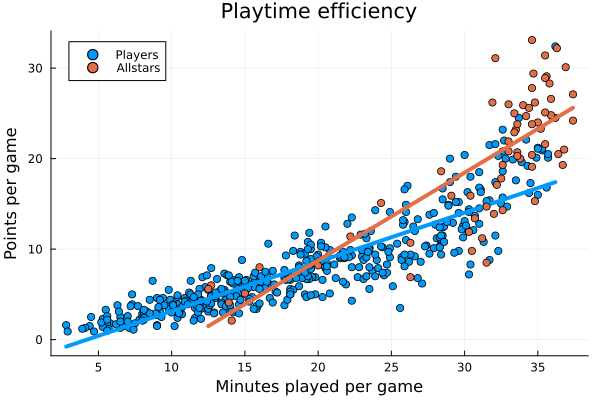

In [93]:
# To make a ColorGradient for Heatmaps: color_palette = cgrad(Sample color scheme = :roma, scale = :log))
@df nbadf scatter(:MP, :PPG, group = :ALLSTAR, 
smooth = true, linewidth = 4,
title = "Playtime efficiency",
xlabel = "Minutes played per game",
ylabel = "Points per game",
label = ["Players" "Allstars"])

The scatterplot of minutes played against points per game appears to be non-linear until the Allstar status is labeled on the points. Then we see that there is not as much of a non-linear relationship but actually two different linear relationships, where Allstars play more minutes and also have a higher rate of scoring points during their playing time.

In [94]:
filter(row->row.ALLSTAR==("Y") && row.MP<25,nbadf)

9×31 DataFrame
 Row │ Player           Pos     Age    Tm      G      GS     MP       FG       ⋯
     │ String           String  Int64  String  Int64  Int64  Float64  Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Andre Drummond   C          29  CHI        67      0     12.7      2.5  ⋯
   2 │ Blake Griffin    C          33  BOS        41     16     13.9      1.5
   3 │ Andre Iguodala   PF         39  GSW         8      0     14.1      0.9
   4 │ DeAndre Jordan   C          34  DEN        39      8     15.0      2.3
   5 │ Kevin Love       PF         34  TOT        62     20     20.0      2.7  ⋯
   6 │ Khris Middleton  SF         31  MIL        33     19     24.3      5.4
   7 │ Derrick Rose     PG         34  NYK        27      0     12.5      2.3
   8 │ Kemba Walker     PG         32  DAL         9      1     16.0      2.7
   9 │ John Wall        PG         32  LAC        34      3     22.2      4.1  ⋯
                                                              23 columns omitted

While most Allstars had high playing time, there appeared to be a few outliers who played less than 25 minutes per game. These players in general were dealing with injuries or older age which limited their play time during this season.

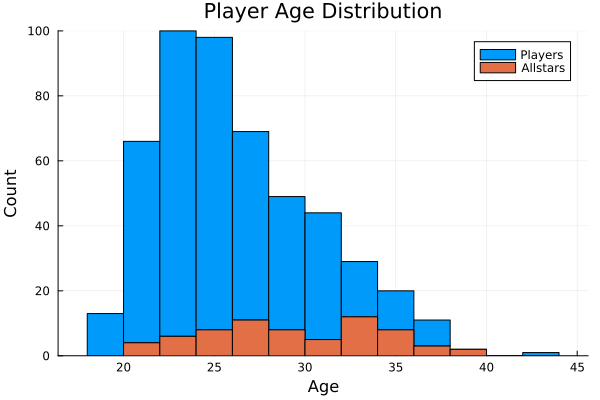

In [95]:
groupedhist(nbadf.Age, group=nbadf.ALLSTAR, bar_position = :stack,
title = "Player Age Distribution",
xlabel = "Age",
ylabel = "Count",
label = ["Players" "Allstars"])

The more even distribution in age for Allstars compared to regular players might be explained by better players lasting longer in their NBA career. Alternatively, being a former Allstar might carry a status that can overcome declining preformance due to player age. Either way, player age appears to be an important factor in differentiating Allstars from regular players.

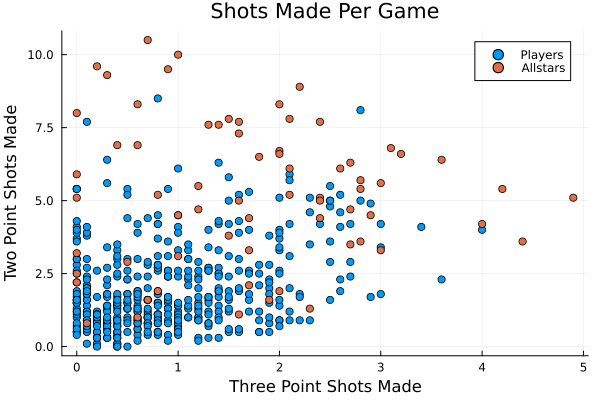

In [96]:
@df nbadf scatter(:ThreeP, :TwoP, group = :ALLSTAR,
title = "Shots Made Per Game",
xlabel = "Three Point Shots Made",
ylabel = "Two Point Shots Made",
label = ["Players" "Allstars"])

Comparing the amount of two and three point shots made by players can show different playing styles but there does not appear to be a distinction between making two or three point shots for Allstars. In this plot, we can see that the Allstars are the ones making the most shots in general with regular players occupying the lower left corner and Allstars dominating the highest point scoring area.

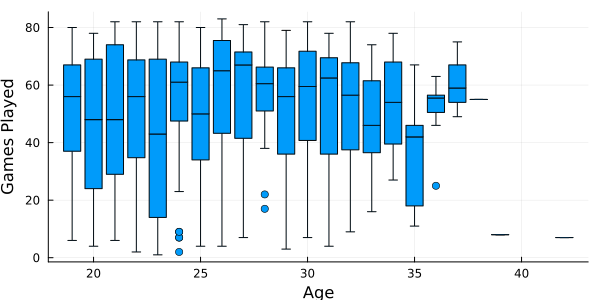

In [97]:
boxplot(nbadf.Age, nbadf.G, xlabel="Age", ylabel="Games Played", label= nothing, 
size=(600, 300))


The number of games played appears relatively constant across ages with a slight dip at older ages. We expect older players to have less stamina than younger players, but this does not seem to be as influential as expected.

## PCA Analysis

A PCA model was fit to the numerical data and just three principle components captured 97.5% of the total dataset variance. The full dataset was used to fit the model instead of the previously reduced data because PCA is not sensitive to multicollinearity and will instead group collinear variables together to negate multicollinearity.
Using the weights of the variables in each principle component will allow us to understand the variables that drive the variance in the data.

In [98]:
features = names(numeric_df)
# load the PCA model
PCA = @load PCA pkg = MultivariateStats

# Standarize -> PCA w/ 97.5% variance.
# The mean = 0 option means we do not need to center the data.
model = Pipeline(Standardizer(), PCA(variance_ratio = 0.975))

# Fit the machine.
mach = machine(model, numeric_df) |> MLJ.fit!

# Apply a transformation to the numeric data and convert to Matrix.
Xproj = MLJ.transform(mach, numeric_df) |> Matrix
;

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/mattbarclay/.julia/packages/MLJModels/iFOi9/src/loading.jl:159
┌ Info: Training machine(UnsupervisedPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/eCnWm/src/machines.jl:493
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/eCnWm/src/machines.jl:493
┌ Info: Training machine(:pca, …).
└ @ MLJBase /Users/mattbarclay/.julia/packages/MLJBase/eCnWm/src/machines.jl:493


In [99]:
r = report(mach).pca

(indim = 26,
 outdim = 3,
 tprincipalvar = 561.2290878071649,
 tresidualvar = 11.286096962736792,
 tvar = 572.5151847699017,
 mean = [25.830677290836654, 50.5, -8.20503470390305e-17, -3.472211451516924e-17, -2.277947640167154e-16, 3.821644196319264e-16, -5.927087063735895e-17, 1.5348501575495193e-16, -1.4154237764145422e-17, -8.536774651500207e-17  …  1.4154237764145422e-16, 1.8577437065440865e-17, 3.2908602801638107e-16, -2.810943155973255e-16, 1.9063988988583366e-16, 1.9639004897751773e-16, 7.364626836656915e-17, 1.8842829023518594e-16, 1.7361057257584619e-16, 9.200254546694525e-17],
 principalvars = [532.9495873536068, 19.14988179532224, 9.129618658235785],
 loadings = [-0.18968092957308486 -4.346222623038481 0.28740158351960704; -23.009579390673995 0.07108423464964402 0.23164761967123212; … ; -0.4635590222705114 -0.11755633401054187 -0.8422635878964636; -0.5194194859625213 -0.10521738593828818 -0.6635534795720351],)

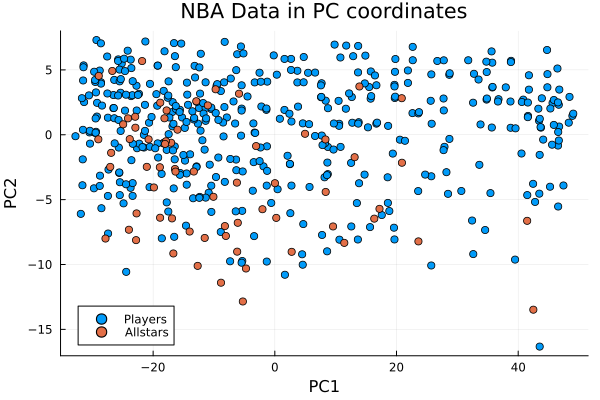

In [100]:
y = nbadf[:, :ALLSTAR] |> Vector
scatter(Xproj[:, 1], Xproj[:, 2],
  group = y,
  title = "NBA Data in PC coordinates",
  xlabel = "PC1",
  ylabel = "PC2",
  label = ["Players" "Allstars"]
)

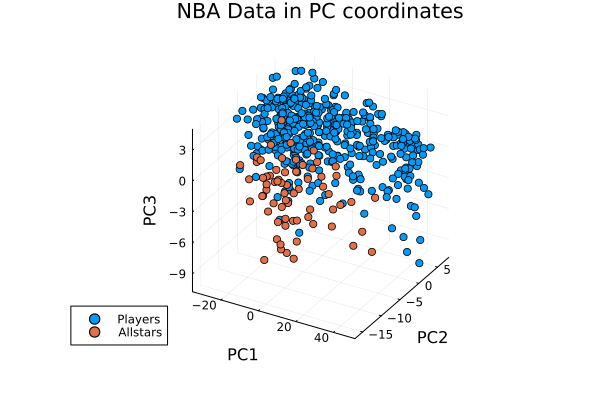

In [101]:
y = nbadf[:, :ALLSTAR] |> Vector
scatter(Xproj[:, 1], Xproj[:, 2], Xproj[:, 3],
  group = y,
  title = "NBA Data in PC coordinates",
  xlabel = "PC1",
  ylabel = "PC2",
  zlabel = "PC3",
  label = ["Players" "Allstars"]
)

In [102]:
L = r.loadings
loadings_df = hcat(
  DataFrame(feature = features),
  DataFrame(L, :auto)
)

rename!(loadings_df, [:feature, :PC1, :PC2, :PC3])
loadings_df

26×4 DataFrame
 Row │ feature    PC1         PC2         PC3        
     │ String     Float64     Float64     Float64    
─────┼───────────────────────────────────────────────
   1 │ Age         -0.189681  -4.34622     0.287402
   2 │ G          -23.0096     0.0710842   0.231648
   3 │ MP          -0.614602  -0.130329   -0.696948
   4 │ FG          -0.468915  -0.103771   -0.847261
   5 │ FGA         -0.464536  -0.0970944  -0.818615
   6 │ FGpct       -0.212716  -0.0570027  -0.207859
   7 │ ThreeP      -0.369803  -0.160813   -0.443563
   8 │ ThreePA     -0.369317  -0.140344   -0.468015
  ⋮  │     ⋮          ⋮           ⋮           ⋮
  20 │ AST         -0.307379  -0.186376   -0.668595
  21 │ STL         -0.407494  -0.088139   -0.513414
  22 │ BLK         -0.268153  -0.0122413  -0.348365
  23 │ TOV         -0.363033  -0.0934114  -0.812697
  24 │ PF          -0.448366  -0.0612659  -0.553793
  25 │ PPG         -0.463559  -0.117556   -0.842264
  26 │ GSpct       -0.519419  -0.105217   -0.663553
                                      11 rows omitted

In the scatterplot of projected principle components 1 and 2, the Allstars appear to be grouped in the negative region of PC1 and mostly negative or zero region of PC2, but there is not a distinct and separate group as regular players are mostly evenly distributed. The most influential variable by far in PC1 is games played with a highly negative weight. As the allstars are almost all in the negative region of PC1, we can conclude that the number of games played has a strong influence on Allstar status. In PC2, age has the greatest weight and is negative, where most of the allstars appear to be located. This confirms what we observed in the histogram above where higher ages seem to distinguish Allstars from regular players. 

In the 3 dimensional scatterplot of all 3 principle components, distinct groups of Allstars annd regular players emerges. While PC3 has the least influence on the overall data variation, it appears to be the component that has the highest impact on grouping the Allstars. Looking at the weights for PC3, there is not a single variable that has an extreme weight like in PC1 and PC2. Overall, the weights in PC3 are negative for all variables except gamse played and age and are the most negative for free throws, two-pointers, field goals, and points per game, indicating that playing better will result in a more negative value in PC3.

By rotating the 3 dimensional scatterplot to see a more 2 dimensional view of just PC2 and PC3, there is a clear boundary between Allstars and regular players where Allstars are in the negative region of both PC2 and PC3 while regular players are in the positive region.

#### Interactive scatterplot from PlotlyJS

In [103]:
# PCA_df = DataFrame(:ALLSTAR=>nbadf[:,:ALLSTAR],:X1=>Xproj[:, 1],:X2=>Xproj[:, 2],:X3=>Xproj[:,3])

# colors = [RGB(18/255, 133/255, 248/255), RGB(217/255, 89/255, 56/255)]
# data = PJS.GenericTrace[]
# df = filter(:ALLSTAR=>==("N"),PCA_df)
# PC1=df[:,:X1]
# PC2=df[:,:X2]
# PC3=df[:,:X3]
# trace = PJS.scatter3d(name="Players", mode="markers",
#                     marker_size=3, marker_color=colors[1], marker_line_width=0,
#                     x=PC1, y=PC2, z=PC3)
# push!(data, trace)
# cluster = PJS.mesh3d(color=colors[1], opacity=0.3, x=PC1, y=PC2, z=PC3)
# push!(data, cluster)

# df = filter(:ALLSTAR=>==("Y"),PCA_df)
# PC1=df[:,:X1]
# PC2=df[:,:X2]
# PC3=df[:,:X3]
# trace = PJS.scatter3d(name="Allstars", mode="markers",
#                     marker_size=3, marker_color=colors[2], marker_line_width=0,
#                     x=PC1, y=PC2, z=PC3)
# push!(data, trace)
# cluster = PJS.mesh3d(color=colors[2], opacity=0.3, x=PC1, y=PC2, z=PC3)
# push!(data, cluster)
# # notice the nested attrs to create complex JSON objects
# layout = PJS.Layout(width=800, height=550, autosize=false, title="Interactive NBA Data in PC coordinates",
#                 scene=PJS.attr(xaxis=PJS.attr(gridcolor="rgb(255, 255, 255)",
#                                         zerolinecolor="rgb(255, 255, 255)",
#                                         showbackground=true,
#                                         backgroundcolor="rgb(230, 230,230)",
#                                         title = "PC1"),
#                             yaxis=PJS.attr(gridcolor="rgb(255, 255, 255)",
#                                         zerolinecolor="rgb(255, 255, 255)",
#                                         showbackground=true,
#                                         backgroundcolor="rgb(230, 230,230)",
#                                         title = "PC2"),
#                             zaxis=PJS.attr(gridcolor="rgb(255, 255, 255)",
#                                         zerolinecolor="rgb(255, 255, 255)",
#                                         showbackground=true,
#                                         backgroundcolor="rgb(230, 230,230)",
#                                         title = "PC3"),
#                             aspectratio=PJS.attr(x=1, y=1, z=0.7),
#                             aspectmode = "manual"),
#                             scene_camera = PJS.attr(eye=PJS.attr(x=1.25, y=-2, z=.75) # Try to match Plots output
#                             ))
# # p = PJS.plot(data, layout)
# # open("./PCA3D.html", "w") do io
# #     PJS.PlotlyBase.to_html(io, p.plot)
# # end

<iframe width=900 height=600 src="./PCA3D.html"></iframe>

# Classification Models

In [104]:
y = categorical(String.(nbadf[!, :ALLSTAR]), ordered = true, levels = ["N", "Y"])
X = select(numeric_df, Not([:FG,:FGA,:FGpct,:ThreePA,:TwoPA,:FTA,:TRB,:eFGpct, :PPG]))
X.Age2 = X.Age.^2 
X.Pos = categorical(nbadf.Pos) 

#Code from Lecture 19
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=206);
acc = Float64[] # accuracy()
pre = Float64[] # multiclass_precision()
rec = Float64[] # multiclass_recall()
f1s = Float64[] # f1score()
mat = []        # confusion_matrix()

Any[]

In [105]:
#Code from Lecture 19
KNNClassifier = @load KNNClassifier verbosity = 0
LDA = @load LDA verbosity = 0
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg = MLJFlux verbosity = 0
#MultinomialClassifier = @load MultinomialClassifier verbosity = 0 #not needed, same as logistic when only 2 classes
DecisionTreeClassifier = @load DecisionTreeClassifier pkg = DecisionTree verbosity=0
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree verbosity=0
LogisticClassifier = @load LogisticClassifier pkg= MLJLinearModels verbosity=0
XGBoostClassifier = @load XGBoostClassifier pkg = XGBoost verbosity=0
model_list = [
    KNNClassifier(K = 5), # use nearest 5-neighbors to make predictions
    LDA(),
    NeuralNetworkClassifier(epochs = 20),
    #MultinomialClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticClassifier(),
    XGBoostClassifier()
]

7-element Vector{Probabilistic}:
 KNNClassifier(K = 5, …)
 LDA(method = gevd, …)
 NeuralNetworkClassifier(builder = Short(n_hidden = 0, …), …)
 DecisionTreeClassifier(max_depth = -1, …)
 RandomForestClassifier(max_depth = -1, …)
 LogisticClassifier(lambda = 2.220446049250313e-16, …)
 XGBoostClassifier(test = 1, …)

In [106]:
#Code from Lecture 19
for clf in model_list
    Random.seed!(206)
    # Create a pipeline model that standardizes, then fits a classifier.
    model = Pipeline(Standardizer(), 
                        OneHotEncoder(),
                        clf)
    # Fit the model onto the training set
    mach = machine(model, X, y)
    fit!(mach, rows = train, verbosity = 0)
    # Make predictions on the test set
    yhat = MLJ.predict(mach, rows = test)
    # Evaluate the model on the test set using selected metrics
    #
    # NOTES:
    #
    #   - MLJ.predict() may give probabilistic predictions. Use mode() to collapse to a concrete target.
    #   - An evaluation metric F() always accepts inputs as F(fitted, observed).
    #
    push!(acc, accuracy(mode.(yhat), y[test]))
    push!(pre, multiclass_precision(mode.(yhat), y[test]))
    push!(rec, multiclass_recall(mode.(yhat), y[test]))
    push!(f1s, f1score(mode.(yhat), y[test]))
    push!(mat, ConfusionMatrix(levels = levels(y))(mode.(yhat), y[test]))
end

In [107]:
#Code from Lecture 19
results = DataFrame(
    Model = typeof.(model_list),
    Accuracy = acc,
    Precision = pre,
    Recall = rec,
    F1 = f1s
)

7×5 DataFrame
 Row │ Model                              Accuracy  Precision  Recall    F1    ⋯
     │ DataType                           Float64   Float64    Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ KNNClassifier                          0.88   0.624113  0.577778  0.25  ⋯
   2 │ LDA                                    0.9    0.75      0.944444  0.666
   3 │ NeuralNetworkClassifier{Short, t…      0.9    0.45      0.5       0.0
   4 │ DecisionTreeClassifier                 0.88   0.679924  0.711111  0.454
   5 │ RandomForestClassifier                 0.95   0.907066  0.794444  0.705 ⋯
   6 │ LogisticClassifier                     0.97   0.933455  0.894444  0.842
   7 │ XGBoostClassifier                      0.93   0.801328  0.827778  0.666
                                                                1 column omitted

The classification model consists of various machine learning algorithms evaluated across multiple metrics including accuracy, precision, recall, and F1 score in order to see how well they can predict outcomes. From the model outputs we can see that all of the models performed well and give high accuracies that are over 85%, and relatively high precisions that are almost all over 70% as well. However, based on the recall and F1 score, we can see that some models rank lower than others such as KNN and Neural Network Classifier. The model that performs the best in all categories is the Logistic Classifier as not only is it’s accuracy and precision high, but its recall and F1 score is the highest out of all of the other models.

### Confusion Matrices

#### KNN

In [108]:
mat[1]  # KNNClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  86  │  8   │
├─────────┼──────┼──────┤
│    Y    │  4   │  2   │
└─────────┴──────┴──────┘


#### LDA

In [109]:
mat[2]  # LDA

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  80  │  0   │
├─────────┼──────┼──────┤
│    Y    │  10  │  10  │
└─────────┴──────┴──────┘


#### Neural Network

In [110]:
mat[3]  # NeuralNetworkClassifier

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  90  │  10  │
├─────────┼──────┼──────┤
│    Y    │  0   │  0   │
└─────────┴──────┴──────┘


#### Decision Tree

In [111]:
mat[4] #Decision Tree

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  83  │  5   │
├─────────┼──────┼──────┤
│    Y    │  7   │  5   │
└─────────┴──────┴──────┘


#### Ridge Regression

In [112]:
mat[5] #Ridge

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  89  │  4   │
├─────────┼──────┼──────┤
│    Y    │  1   │  6   │
└─────────┴──────┴──────┘


#### Logistic Regression

In [113]:
mat[6] #Logistic

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  89  │  2   │
├─────────┼──────┼──────┤
│    Y    │  1   │  8   │
└─────────┴──────┴──────┘


#### XGBoost

In [114]:
mat[7] #XGBoost

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  N   │  Y   │
├─────────┼──────┼──────┤
│    N    │  86  │  3   │
├─────────┼──────┼──────┤
│    Y    │  4   │  7   │
└─────────┴──────┴──────┘


### Logistic Regression Coefficients

In [115]:
model = Pipeline(Standardizer(), OneHotEncoder(), LogisticClassifier())
    # Fit the model onto the training set
    mach = machine(model, X, y)
    fit!(mach, verbosity = 0)
fitted_params(mach).logistic_classifier.coefs |> DataFrame
#MLJ.predict(mach)

1×23 DataFrame
 Row │ Age        G           MP        ThreeP    ThreePpct   TwoP     TwoPpct ⋯
     │ Float64    Float64     Float64   Float64   Float64     Float64  Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ -0.466925  -0.0201024  0.306384  0.205087  0.00722874  0.39539  0.04512 ⋯
                                                              17 columns omitted

For the logistic regression coefficients, it is important to note that the lower/negative coefficients are more likely to be a regular player and the higher/positive coefficients are more likely to be an Allstar. We found games played and all positions except point guard to be correlated with being a regular player. The most influential predictors for being an Allstar are 2 point shots made, turnovers, minutes played, and the percentage of games started. Curiously, Turnovers (TOV) is correlated with Allstars, which may be explained by them having possession of the ball more often so they will be more susceptible to losing possession. The first degree Age coefficient is very negative while the second degree Age coefficient is positive, so age appears to decrease likelihood of being an Allstar until it is at the highest age values.

## Conclusion

Based on our analysis we have enough evidence to determine that we have enough valid information to solve the original research question on what factors make an NBA All-star player. While many factors contribute to determining the selection of an All-star player, the main inferences we identified during our analysis are that the minutes played and the points a player has per game plays significant roles in a player’s career as they are relied on more to win games hence elevating them up to an All-star caliber player. 

Age was not found to be as influential as we originally thought it would be, though it does have some bearing on Allstar status. From the PCA model, we found that the principle component with a heavy age weight was useful to separate Allstars from regular players when also looking at their overall offensive performance. In Logistic regression, the age term indicated that Allstar status decreased in probability non-linearly but that higher ages would have a higher probability of being labeled an Allstar.

**Future Considerations**

To extend this project’s complexity, we should consider implementing cross-validation of current model performances and constructing enhanced models to predict a rookie players’ potential to become an all star, applying this project to future seasons. Performing cross validation will provide assurance and verify the absence of high error (R^2, RMSE, etc.) models; plotting model residuals would be a valuable addition. Predicting whether a rookie has the potential to become an all star is challenging and perhaps another project in itself. For this, we would collect more seasonal historical data to understand just how a rookie evolves into an all star player. A case study would be an optimal approach, allowing for an in-depth analysis of metrics contributing to a given player’s upward trajectory throughout their career. Subsequently, we would employ this methodology to anticipate a rookie’s potential in the current season and project it into the future. However, one caveat to this method is a forecast with a hard maximum of 5 years as statistically, beyond, predictions often deteriorate. Considerations such as these need to be methodically planned and fine-tuned to establish practicality because after all, “theory can only take you so far.”
